### ay data need to be in the NetCDF before the debiasing the ACS chl
#### Note: this is based on the NASA HPLC xls file for AMT29

In [1]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal as sg
from datetime import datetime as dt

In [3]:
%matplotlib notebook

In [4]:
def prcrng(x):
    return (np.nanpercentile(x,84) - np.nanpercentile(x,16))/2.

In [5]:
DIN_hplc = "/data/datasets/cruise_data/active/AMT27/HPLC/"
DIN_acs = "~/scratch_network/AMT_underway/AMT27/Processed/Underway/Step3/"

In [6]:
fn_hplc =  "Results DAN_2018_019.xlsx"
fn_meta = "AMT27_Station_log_Tilstone_forBODC.xlsx"
fn_optics = "amt27_final.nc"

In [7]:
# mods made to file reader for AMT 27
df_hplc = pd.read_excel(DIN_hplc + fn_hplc, sheet_name = "csv", header = 0, engine = 'openpyxl', nrows=51) # nrows used, so that only hplc data with corresponding meta data us selected
df_hplc = df_hplc.drop(labels=[0,1,2], axis=0)
df_hplc = df_hplc.rename(columns={"Unnamed: 0": "Label"})    # Label == sample ID 
df_hplc = df_hplc.rename(columns={"Unnamed: 1": "Volume"})      
df_hplc = df_hplc.rename(columns={"Unnamed: 2": "DHI no"})   
df_hplc = df_hplc.reset_index(drop=True)
for i in range(len(df_hplc)): # convert to same Label format as AMT27 metadata
       df_hplc["Label"][i] =  'UW' + str(df_hplc["Label"][i][-3:])
        
df_hplc

,Label,Volume,DHI no,Chlorophyll c3,Chlorophyll c1+c2,Chlorophyllide a,Pheophorbide a,Peridinin,19-but-fucoxanthin,Fucoxanthin,...,Alloxanthin,Diatoxanthin,Zeaxanthin,Lutein,Chl C2 MGDG,Chlorophyll b,DV chlorophyll a,MV chlorphyll a,Pheophytin a,a+b-carotene
0,UW001,2,1,0.037777,0.045214,0.006699,0,0.005403,0.029827,0.046949,...,0.008791,0.003368,0.009048,0.000569,0.004047,0.027787,0,0.305818,0,0.008466
1,UW004,4,2,0.026867,0.030127,0.005976,0,0.013962,0.032054,0.011075,...,0,0.004942,0.088555,0.001005,0.001881,0.02156,0.096051,0.1874,0.004394,0.014154
2,UW008,4,3,0.01667,0.020773,0.00429,0,0.004872,0.021925,0.008589,...,0,0.000818,0.079536,0.000755,0,0.015374,0.084623,0.122662,0,0.011796
3,UW010,4,4,0.006418,0.009704,0.000841,0,0.002423,0.010068,0.004947,...,0,0.000289,0.049266,0.000418,0,0.007561,0.052555,0.053854,0,0.007449
4,UW014,4,5,0.003972,0.005519,0.001588,0,0.001161,0.008036,0.004991,...,0,0.000651,0.04246,0.000381,0,0.004042,0.033035,0.042891,0,0.005016
5,UW016,5,6,0.003457,0.006134,0.001604,0,0.001075,0.005904,0.004406,...,0,0.000027,0.056803,0.000276,0,0.004575,0.0453,0.04148,0,0.006417
6,UW019,5,7,0.002632,0.005408,0.00116,0,0.001493,0.005492,0.003674,...,0,0.000609,0.051584,0.005375,0,0.037777,0.029155,0.077406,0.004791,0.007676
7,UW023,4,8,0.001686,0.0039,0.001257,0,0.001174,0.003426,0.002238,...,0,0.000807,0.03105,0.000375,0,0.002408,0.011392,0.033138,0,0.003389
8,UW027,5,9,0.002094,0.004392,0.000715,0,0.001018,0.003494,0.002089,...,0,0.000121,0.02569,0.00038,0,0.00408,0.011037,0.034414,0,0.003363
9,UW030,5,10,0.003753,0.004732,0.003659,0.006089,0.001195,0.004037,0.003644,...,0,0.000342,0.049242,0.000369,0,0.007011,0.026445,0.077845,0.001862,0.009249


In [8]:
df_meta = pd.read_excel(DIN_hplc + fn_meta, sheet_name = "AMT27_Underway_HPLC", header = 1, engine = 'openpyxl')

# fields to rename
df_meta = df_meta.rename(columns={"Description": "Label"})  # Description == label == sample ID 
df_meta = df_meta.rename(columns={"Time at surface": "Time"})
df_meta = df_meta.rename(columns={"lat": "Lat"}) # this is decimal lat, lon 
df_meta = df_meta.rename(columns={"lon": "Lon"})
df_meta = df_meta.rename(columns={"Julian Day": "SDY"})
df_meta = df_meta.rename(columns={"HPLC, Vol filtered (litres)": "Volume"})

# fields to remove
df_meta = df_meta.drop('Latitude', axis=1) # integer latitude
df_meta = df_meta.drop('minutes', axis=1) # arc mins 
df_meta = df_meta.drop('Decimal', axis=1) # arc secs
df_meta = df_meta.drop('Unnamed: 3', axis=1) # redundant
df_meta = df_meta.drop('Unnamed: 4', axis=1) # redundant
df_meta = df_meta.drop('Longitude', axis=1) # integer longitude 
df_meta = df_meta.drop('minutes.1', axis=1) # arc mins 
df_meta = df_meta.drop('Decimal.1', axis=1) # arc secs
df_meta = df_meta.drop('Unnamed: 8', axis=1) # redundant
df_meta = df_meta.drop('Unnamed: 9', axis=1) # redundant
df_meta = df_meta.drop('Time at depth', axis=1) #  blanks in xls - Time surface used for time
df_meta = df_meta.drop('Time on deck', axis=1) #  blanks in xls
df_meta = df_meta.drop('time', axis=1) #  decimal time: not used
df_meta = df_meta.drop('Volume', axis=1) # already given in hplc table

df_meta.keys()


Index(['Date', 'SDY', 'Time', 'Cast No.', 'Lat', 'Lon', 'Label', 'Depth',
       'Secchi Depth', 'Comments'],
      dtype='object')

In [9]:
# merge two tables to extract info from df_meta
df_hplc = pd.merge(df_hplc, df_meta, on=['Label'])
# df_hplc.keys()

In [10]:

# convert DHI pigment names to NASA pigment names for submission
#                            DHI  :  NASA
dhi2nasa = {      "Chlorophyll c3":"Chl_c3",
#                 "Chlorophyll c2":"Chl c1c2", # these two successive pigments need to be merged (see below)
#           "Chlorophyll c1+MgDVP":"Chl c1c2",
                "Chlorophyllide a":"Chlide_a",
                  "Pheophorbide a":"Phide_a",
                       "Peridinin":"Perid",
              "19-but-fucoxanthin":"But-fuco",
                     "Fucoxanthin":"Fuco",
                      "Neoxanthin":"Neo",
                  "Prasinoxanthin":"Pras",
                    "Violaxanthin":"Viola",
              #"19-Hex-fucoxanthin":"Hex-fuco", AMT 28
              "19-hex-fucoxanthin":"Hex-fuco", # AMT 27
                     "Astaxanthin":"DHI_only_Astaxanthin",
                  "Diadinoxanthin":"Diadino",
            "Myxoxanthophyll-like":"DHI_only_Myxoxanthophyll-like",
                     "Alloxanthin":"Allo",
                    "Diatoxanthin":"Diato",
                      "Zeaxanthin":"Zea",
                          "Lutein":"Lut",
                     "Chl C2 MGDG":"DHI_only_Chl_C2_MGDG",
                   "Chlorophyll b":"Tot_Chl_b",
                "DV chlorophyll a":"DV_Chl_a",
               # "MV chlorophyll a":"MV_Chl_a", # AMT28 - DHI correctly spelt
                 "MV chlorphyll a":"MV_Chl_a",  #  AMT27 - DHI incorrect spelling?
                    "Pheophytin a":"Phytin_a"}
#                     "a-carotene":"Alpha-beta-Car", # these two successive pigments need to be merged (see below)
#                     "b-carotene":"Alpha-beta-Car"}

# rename DHI columns with NASA names
df_hplc = df_hplc.rename(columns = dhi2nasa)


# Create merged pigments
# "Alpha-beta-Car", 
# df_hplc["Alpha-beta-Car"] = df_hplc["a-carotene"] + df_hplc["b-carotene"] # this was used to merge for AMT28
# df_hplc = df_hplc.drop(columns=["a-carotene", "b-carotene"])
df_hplc = df_hplc.rename(columns={'a+b-carotene': "Alpha-beta-Car"})  # for AMT27, already merged & we simpy rename 

           
# "Chl c1c2"
# df_hplc["Chl_c1c2"] = df_hplc["Chlorophyll c2"] + df_hplc["Chlorophyll c1+MgDVP"]  # this was used to merge for AMT28
# df_hplc = df_hplc.drop(columns=["Chlorophyll c2", "Chlorophyll c1+MgDVP"])
df_hplc = df_hplc.rename(columns={'Chlorophyll c1+c2': "Chl_c1c2"})   # for AMT27, already merged & we simpy rename 


# "Tot_Chl_a" = DV_Chl_a + MV_Chl_a + Chlide_a (+ Chl_a allomers + Chl_a epimers)
df_hplc["Tot_Chl_a"] = df_hplc["DV_Chl_a"] + df_hplc["MV_Chl_a"] + df_hplc["Chlide_a"]

# "Tot_Chl_c" = Tot_Chl_a + Tot_Chl_b + Tot_Chl_c
df_hplc["Tot_Chl_c"] = df_hplc["Chl_c3"] + df_hplc["Chl_c1c2"]

# "Tchl" = Tot_Chl_a + Tot_Chl_b + Tot_Chl_c
df_hplc["Tchl"] = df_hplc["Tot_Chl_a"] + df_hplc["Tot_Chl_b"] + df_hplc["Tot_Chl_c"]

# "PPC" (photoprotective carotenoids) = allo + diadino + diato + zea + alpha-beta-car)
df_hplc["PPC"] = df_hplc["Allo"] + df_hplc["Diadino"] + df_hplc["Diato"] + df_hplc["Zea"] + df_hplc["Alpha-beta-Car"]

# "PSC" (photosynthetic carotenoids) = but-fuco + fuco + hex-fuco + perid)
df_hplc["PSC"] = df_hplc["But-fuco"] + df_hplc["Fuco"] + df_hplc["Hex-fuco"] + df_hplc["Perid"] 

# "PSP" (phosynthetic pigments) = PSC + TChl
df_hplc["PSP"] = df_hplc["PSC"] + df_hplc["Tchl"] 

# "Tcar" (total carotenoids) = PPC + PSC
df_hplc["Tcar"] = df_hplc["PPC"] + df_hplc["PSC"] 

# "Tacc" (total accessory pigments) = PPC + PSC + Tot_Chl_b + Tot_Chl_c 
df_hplc["Tacc"] = df_hplc["PPC"] + df_hplc["PSC"] + df_hplc["Tot_Chl_b"] + df_hplc["Tot_Chl_c"] 

# "Tpg" (total pigments) = TAcc + Tot_Chl_a
df_hplc["Tpg"] = df_hplc["Tacc"] + df_hplc["Tot_Chl_a"] 

# "DP" (total diagnostic pigments) = PSC + allo + zea + Tot_Chl_b
df_hplc["DP"] = df_hplc["PSC"] + df_hplc["Allo"] + df_hplc["Zea"] + df_hplc["Tot_Chl_b"]


# new dictionary with additional pigments
derived_pigs = {"Alpha-beta-Car":"Alpha-beta-Car",
                "Chl_c1c2":"Chl_c1c2",
                "Tot_Chl_a":"Tot_Chl_a",
                "Tot_Chl_c":"Tot_Chl_c",
                "Tchl":"Tchl",
                "PPC":"PPC",
                "PSC":"PSC",
                "PSP":"PSP",
                "Tcar":"Tcar",
                "Tacc":"Tacc",
                "Tpg":"Tpg",
                "DP":"DP"      }

df_hplc.keys()


Index(['Label', 'Volume', 'DHI no', 'Chl_c3', 'Chl_c1c2', 'Chlide_a',
       'Phide_a', 'Perid', 'But-fuco', 'Fuco', 'Neo', 'Pras', 'Viola',
       'Hex-fuco', 'DHI_only_Astaxanthin', 'Diadino', 'Allo', 'Diato', 'Zea',
       'Lut', 'DHI_only_Chl_C2_MGDG', 'Tot_Chl_b', 'DV_Chl_a', 'MV_Chl_a',
       'Phytin_a', 'Alpha-beta-Car', 'Date', 'SDY', 'Time', 'Cast No.', 'Lat',
       'Lon', 'Depth', 'Secchi Depth', 'Comments', 'Tot_Chl_a', 'Tot_Chl_c',
       'Tchl', 'PPC', 'PSC', 'PSP', 'Tcar', 'Tacc', 'Tpg', 'DP'],
      dtype='object')

In [11]:
# merge dictonaries with names of all pigments
all_pigs = dict(dhi2nasa, **derived_pigs)

In [12]:
# find matching keys and merge them into a single one
for key in df_hplc.keys():
    if "_x" in key:
        print(key)
        if ~(np.all(df_hplc[key] == df_hplc[key[:-1]+"y"])):
            print([key, " not matching"])
        else:
            # drop *_x key
            print(["droppping " + key ])
            df_hplc = df_hplc.drop(columns = [key])
            # rename *_y key
            print(["renaming " + key ])
            df_hplc = df_hplc.rename(columns = {key[:-1]+"y" : key[:-2]})
            

In [13]:
# convert date (numpy.datetime64) and time (datetime.time) to a single datetime object
from datetime import datetime as dt

# convert date from (numpy.datetime64) to (datetime.time) 
ts = (df_hplc.Date - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
newts = [dt.utcfromtimestamp(tsi) for tsi in ts]

# add Time object to Date object to get DateTime object
mydatetime = [dt.combine(newts[i], df_hplc.Time.values[i]) for i,j in enumerate(df_hplc.Time)  ]

# create "Time" key in df_hplc
df_hplc['time'] = mydatetime

# drop Date and Time
df_hplc = df_hplc.drop(columns = ["Date", "Time"])
                       
df_hplc = df_hplc.sort_values(by = ['time'])
df_hplc = df_hplc.reset_index(drop = True)

df_hplc

/tmp/ipykernel_296975/1994418988.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  ts = (df_hplc.Date - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


,Label,Volume,DHI no,Chl_c3,Chl_c1c2,Chlide_a,Phide_a,Perid,But-fuco,Fuco,...,Tot_Chl_c,Tchl,PPC,PSC,PSP,Tcar,Tacc,Tpg,DP,time
0,UW001,2,1,0.037777,0.045214,0.006699,0,0.005403,0.029827,0.046949,...,0.08299,0.423294,0.055782,0.194621,0.617915,0.250403,0.36118,0.673697,0.240247,2017-09-24 17:27:00
1,UW004,4,2,0.026867,0.030127,0.005976,0,0.013962,0.032054,0.011075,...,0.056994,0.36798,0.137715,0.138058,0.506038,0.275773,0.354327,0.643754,0.248173,2017-09-25 11:57:00
2,UW008,4,3,0.01667,0.020773,0.00429,0,0.004872,0.021925,0.008589,...,0.037444,0.264393,0.102062,0.084628,0.349021,0.18669,0.239508,0.451083,0.179538,2017-09-26 11:00:00
3,UW010,4,4,0.006418,0.009704,0.000841,0,0.002423,0.010068,0.004947,...,0.016122,0.130933,0.06185,0.039312,0.170245,0.101162,0.124846,0.232095,0.09614,2017-09-26 15:00:00
4,UW014,4,5,0.003972,0.005519,0.001588,0,0.001161,0.008036,0.004991,...,0.009491,0.091047,0.054727,0.02806,0.119108,0.082787,0.096321,0.173835,0.074563,2017-09-27 18:52:00
5,UW016,5,6,0.003457,0.006134,0.001604,0,0.001075,0.005904,0.004406,...,0.009591,0.10255,0.071664,0.026595,0.129145,0.09826,0.112426,0.20081,0.087973,2017-09-28 10:56:00
6,UW019,5,7,0.002632,0.005408,0.00116,0,0.001493,0.005492,0.003674,...,0.008041,0.153538,0.065733,0.024004,0.177542,0.089737,0.135555,0.243275,0.113366,2017-09-29 19:00:00
7,UW023,4,8,0.001686,0.0039,0.001257,0,0.001174,0.003426,0.002238,...,0.005586,0.05378,0.040693,0.017627,0.071407,0.05832,0.066313,0.1121,0.051084,2017-10-01 18:03:00
8,UW027,5,9,0.002094,0.004392,0.000715,0,0.001018,0.003494,0.002089,...,0.006487,0.056733,0.03309,0.018205,0.074937,0.051295,0.061861,0.108027,0.047974,2017-10-03 09:06:00
9,UW030,5,10,0.003753,0.004732,0.003659,0.006089,0.001195,0.004037,0.003644,...,0.008485,0.123444,0.065689,0.025193,0.148637,0.090882,0.106378,0.214326,0.081446,2017-10-03 21:07:00


In [14]:
# clean up lat
# In[14]: # step 14 is commented out for AMT 27, as Lat, Lon are already
# given in degrees

# clean up lat
# tmpla = df_hplc['Lat'].values
# for i,la in enumerate(tmpla):
#    if (type(la) != float) & (type(la) != int):
#         print(type(la))
#         print(i, "    ", la)
        # assume the string is similar to "31°31.784'W"
        
        # replace "º" by "°"
#        la = la.replace("º", "°")
        
#        degrees = float(la.split("°")[0]) 
#        minutes = float(la.split("°")[-1].split("'")[0])
#        NoS = la.split("°")[-1].split("'")[-1]
#        sign = -1
#        if (NoS.upper() == "N"):
#           sign = 1
#        df_hplc.at[i, 'Lat'] = sign*(degrees + minutes/60.)

# clean up lon
# tmplo = df_hplc['Lon'].values
# for i,lo in enumerate(tmplo):
#    if (type(lo) != float) & (type(lo) != int):
#         print(type(lo))
#         print(i, "    ", lo)
        # assume the string is similar to "31°31.784'"
        
        # replace "º" by "°"
#        lo = lo.replace("º", "°")
        
#        degrees = float(lo.split("°")[0]) 
#        minutes = float(lo.split("°")[-1].split("'")[0])
#        EoW = lo.split("°")[-1].split("'")[-1]
#        sign = -1
#        if (EoW.upper() == "E"):
#            sign = 1
#        df_hplc.at[i, 'Lon'] = s


In [15]:
# extract surface data

# replace UND label with nominal depth of rUNDerway measurements
#df_hplc.Depth[df_hplc.Depth=="UND"] = 7 - not used in AMT27?

isurf = df_hplc["Depth"]<10
df_hplc_surf = df_hplc[isurf]
df_hplc_surf = df_hplc_surf.set_index("time")
df_hplc_surf



,Label,Volume,DHI no,Chl_c3,Chl_c1c2,Chlide_a,Phide_a,Perid,But-fuco,Fuco,...,Tot_Chl_a,Tot_Chl_c,Tchl,PPC,PSC,PSP,Tcar,Tacc,Tpg,DP
time,,,,,,,,,,,,,,,,,,,,,
2017-09-24 17:27:00,UW001,2,1,0.037777,0.045214,0.006699,0,0.005403,0.029827,0.046949,...,0.312517,0.08299,0.423294,0.055782,0.194621,0.617915,0.250403,0.36118,0.673697,0.240247
2017-09-25 11:57:00,UW004,4,2,0.026867,0.030127,0.005976,0,0.013962,0.032054,0.011075,...,0.289426,0.056994,0.36798,0.137715,0.138058,0.506038,0.275773,0.354327,0.643754,0.248173
2017-09-26 11:00:00,UW008,4,3,0.01667,0.020773,0.00429,0,0.004872,0.021925,0.008589,...,0.211575,0.037444,0.264393,0.102062,0.084628,0.349021,0.18669,0.239508,0.451083,0.179538
2017-09-26 15:00:00,UW010,4,4,0.006418,0.009704,0.000841,0,0.002423,0.010068,0.004947,...,0.107249,0.016122,0.130933,0.06185,0.039312,0.170245,0.101162,0.124846,0.232095,0.09614
2017-09-27 18:52:00,UW014,4,5,0.003972,0.005519,0.001588,0,0.001161,0.008036,0.004991,...,0.077514,0.009491,0.091047,0.054727,0.02806,0.119108,0.082787,0.096321,0.173835,0.074563
2017-09-28 10:56:00,UW016,5,6,0.003457,0.006134,0.001604,0,0.001075,0.005904,0.004406,...,0.088384,0.009591,0.10255,0.071664,0.026595,0.129145,0.09826,0.112426,0.20081,0.087973
2017-09-29 19:00:00,UW019,5,7,0.002632,0.005408,0.00116,0,0.001493,0.005492,0.003674,...,0.10772,0.008041,0.153538,0.065733,0.024004,0.177542,0.089737,0.135555,0.243275,0.113366
2017-10-01 18:03:00,UW023,4,8,0.001686,0.0039,0.001257,0,0.001174,0.003426,0.002238,...,0.045787,0.005586,0.05378,0.040693,0.017627,0.071407,0.05832,0.066313,0.1121,0.051084
2017-10-03 09:06:00,UW027,5,9,0.002094,0.004392,0.000715,0,0.001018,0.003494,0.002089,...,0.046166,0.006487,0.056733,0.03309,0.018205,0.074937,0.051295,0.061861,0.108027,0.047974


In [16]:
# read ACS data
fn_acs = fn_optics
acs = xr.open_dataset(DIN_acs+fn_acs)
acs.close()


if "uway_long" in acs.keys():
  #  acs.uway_lon = acs.uway_long # tjor - command did not work 
    acs['uway_lon'] = acs['uway_long']
    acs = acs.drop(labels="uway_long")
    
acs

<xarray.Dataset>
Dimensions:                      (time: 56160, acs_wv: 176, ac9_wv: 9, bb3_wv: 3)
Coordinates:
  * time                         (time) datetime64[ns] 2017-09-24 ... 2017-11...
  * acs_wv                       (acs_wv) float64 400.0 402.0 ... 748.0 750.0
  * ac9_wv                       (ac9_wv) float64 nan nan nan ... nan nan nan
  * bb3_wv                       (bb3_wv) float64 470.0 532.0 700.0
Data variables: (12/45)
    flow                         (time) float64 ...
    acs_chl                      (time) float64 ...
    acs_ap                       (time, acs_wv) float64 ...
    acs_ap_u                     (time, acs_wv) float64 ...
    acs_bp                       (time, acs_wv) float64 ...
    acs_bp_u                     (time, acs_wv) float64 ...
    ...                           ...
    uway_tir2                    (time) float64 ...
    uway_sal                     (time) float64 ...
    uway_sst                     (time) float64 ...
    uway_thermosalinograph_temp  (time) float64 ...
    uway_conductivity            (time) float64 ...
    uway_lon                     (time) float64 ...

In [17]:
# fig, ax = plt.subplots(2,1, figsize=[12,6], sharex=True)
# ax[0].plot(acs.time, acs.uway_lon, '.')
# ax[1].plot(acs.time, acs.uway_lat, '.')


In [18]:


# 


# ### Add HPLC data to NetCDF 

### Add HPLC data to NetCDF file

In [19]:
# convert to lower case some keys in hplc dataframe
if "Lon" in  df_hplc_surf:
    df_hplc_surf = df_hplc_surf.rename(columns = {"Lon":"lon"})
if "Lat" in  df_hplc_surf:
    df_hplc_surf = df_hplc_surf.rename(columns = {"Lat":"lat"})
if "Time" in  df_hplc_surf:
    df_hplc_surf = df_hplc_surf.rename(columns = {"Time":"time"})
if "Depth" in  df_hplc_surf:
    df_hplc_surf = df_hplc_surf.rename(columns = {"Depth":"depth"})


In [20]:
df_hplc_surf.keys()

Index(['Label', 'Volume', 'DHI no', 'Chl_c3', 'Chl_c1c2', 'Chlide_a',
       'Phide_a', 'Perid', 'But-fuco', 'Fuco', 'Neo', 'Pras', 'Viola',
       'Hex-fuco', 'DHI_only_Astaxanthin', 'Diadino', 'Allo', 'Diato', 'Zea',
       'Lut', 'DHI_only_Chl_C2_MGDG', 'Tot_Chl_b', 'DV_Chl_a', 'MV_Chl_a',
       'Phytin_a', 'Alpha-beta-Car', 'SDY', 'Cast No.', 'lat', 'lon', 'depth',
       'Secchi Depth', 'Comments', 'Tot_Chl_a', 'Tot_Chl_c', 'Tchl', 'PPC',
       'PSC', 'PSP', 'Tcar', 'Tacc', 'Tpg', 'DP'],
      dtype='object')

In [21]:
# create hplc_time coordinate
acs = acs.assign_coords(coords={'hplc_time' : (['hplc_time'], df_hplc_surf.index, {'time zone' : 'UTC'}) })
acs.hplc_time.encoding['units'] = "seconds since 1970-01-01 00:00:00"
acs.hplc_time.encoding['calendar'] = "proleptic_gregorian"


In [22]:
# #### read HPLC metadata on pigments (if NASA)
# hplc_pignm = pd.read_excel(DIN_hplc + fn_hplc, sheet_name = "information", header = 4, engine = 'openpyxl',
#                         nrows = 38, usecols = [1, 3, 4, 12, 13, 14], dtype=str)

# # shift info around in original table
# df1 = hplc_pignm.iloc[:, [0,1,2]]
# df2 = hplc_pignm.iloc[:, [3,4,5]] 
# df2 = df2.rename(columns={ df2.keys()[0]: 'abbreviation',
#                      df2.keys()[1]: 'name',
#                      df2.keys()[2]: 'notes'
#                     })
# df1 = df1.rename(columns={ df1.keys()[0]: 'abbreviation',
#                      df1.keys()[1]: 'name',
#                      df1.keys()[2]: 'notes'
#                     })
# # concatenate to subsets of attributes
# df1 = df1.append(df2, ignore_index=True)

# # find indices with empty abbreviations and drop them
# ind = []
# for irow in range(len(df1['abbreviation'].values)):
#     if type(df1['abbreviation'].values[irow])==float:
#         ind.append(irow)
    
# df_hplc_pignm = df1.drop(ind)    


In [23]:
# df_hplc.plot.scatter(x='lat', y='DV_Chl_b', xlim=(-60,60), ylim=(0,0.3), marker='o', grid='on', alpha=0.5)

In [24]:
### add HPLC variables to acs dataset
# drop time-related columns
if 'year' in df_hplc_surf.keys():
    df_hplc_surf = df_hplc_surf.drop(columns=['year', 'month', 'day', 'sdy',
                               'water_depth', 'name of water body' ])
df_hplc_surf.keys()

Index(['Label', 'Volume', 'DHI no', 'Chl_c3', 'Chl_c1c2', 'Chlide_a',
       'Phide_a', 'Perid', 'But-fuco', 'Fuco', 'Neo', 'Pras', 'Viola',
       'Hex-fuco', 'DHI_only_Astaxanthin', 'Diadino', 'Allo', 'Diato', 'Zea',
       'Lut', 'DHI_only_Chl_C2_MGDG', 'Tot_Chl_b', 'DV_Chl_a', 'MV_Chl_a',
       'Phytin_a', 'Alpha-beta-Car', 'SDY', 'Cast No.', 'lat', 'lon', 'depth',
       'Secchi Depth', 'Comments', 'Tot_Chl_a', 'Tot_Chl_c', 'Tchl', 'PPC',
       'PSC', 'PSP', 'Tcar', 'Tacc', 'Tpg', 'DP'],
      dtype='object')

In [25]:
## for NASA only
# df_hplc_pignm.abbreviation.values

In [26]:
# if NASA

# # find names of hplc vars
# hplc_cols = df_hplc_surf.keys()
# #add attributes to each variable and add it to acs xr dataset
# _var = ()
# _attrs = {}
# for ivar in hplc_cols:
# #     print(ivar)
#     lbl = ivar.replace(" ", "_").replace("__", "_") # repalce spaces with _
#     print(lbl)
    
#     if 'diameter' in ivar:
#         lbl = lbl[:-5]
#         _attrs = {'units': 'mm'}
#         _var = (['hplc_time'], df_hplc[ivar] ) 
    
#     elif lbl in df_hplc_pignm['abbreviation'].values:
#         # find index of df_hplc_pignm ivar
#         ik = list(df_hplc_pignm['abbreviation']).index(lbl)
# #         print("^^^^^^^^^^^this is a pigment")
#         _attrs = {'units' : 'mg/m3',
#                   'full_pigment_name' : df_hplc_pignm['name'].values[ik],
#                   'notes' : df_hplc_pignm['notes'].values[ik]}
#         _var = (['hplc_time'], df_hplc[ivar])
# #             print(_var)
#     else:
# #         print('nothing to do: ' + ivar)
#         _attrs = {}
#         _var = (['hplc_time'], df_hplc[ivar]) 
        
        
#     acs['hplc_'+lbl] = _var
#     acs['hplc_'+lbl].attrs = _attrs
    
#     # reset _var and _attrs
#     _var = ()
#     _attras = {}
    
# #     print(lbl)


# ## HOW TO CHECK THAT ALL PIGMENTS HAVE HAD THEIR ATTRIBUTES?

In [27]:
pigs_names = {value:key for key, value in all_pigs.items()} 
# pigs_names

In [28]:
# find names of hplc vars
hplc_cols = df_hplc_surf.keys()
#add attributes to each variable and add it to acs xr dataset
_var = ()
_attrs = {}
for ivar in hplc_cols:
#     print(ivar)
    lbl = ivar.replace(" ", "_").replace("__", "_") # repalce spaces with _

    
    if 'diameter' in ivar:
        lbl = lbl[:-5]
        _attrs = {'units': 'mm'}
        _var = (['hplc_time'], df_hplc_surf[ivar] ) 
        acs['hplc_'+lbl.lower()] = _var
        acs['hplc_'+lbl.lower()].attrs = _attrs
#         print(["NOT A PIGM: "+lbl.lower()])
        
    elif lbl in pigs_names.keys():
#         print("^^^^^^^^^^^this is a pigment")
        _attrs = {'units' : 'mg/m3'}
        _var = (['hplc_time'], df_hplc_surf[ivar])
#             print(_var)
        acs['hplc_'+lbl] = _var   # previously this was hplc_pigs_
        acs['hplc_'+lbl].attrs = _attrs
#         print(lbl)
        
    else:
#         print('nothing to do: ' + ivar)
        _attrs = {}
        _var = (['hplc_time'], df_hplc_surf[ivar]) 
        acs['hplc_'+lbl.lower()] = _var
        acs['hplc_'+lbl.lower()].attrs = _attrs
#         print(["NOT A PIGM: "+lbl.lower()])
        
    
    # reset _var and _attrs
    _var = ()
    _attras = {}
    
#     print(lbl)


## HOW TO CHECK THAT ALL PIGMENTS HAVE HAD THEIR ATTRIBUTES?

In [29]:
# var = 'hplc_filter_storage_before_shipment_to_GFC'
# ty = [type(acs[var].values[i]) for i,tmp in enumerate(acs[var].values)]

# if ~np.all([ty[i]==ty[0] for i,tmp in enumerate(ty)]):
#     print(ty)


In [30]:
"hplc_ctd" in acs.keys()

False

In [31]:
# ensure that hplc_variables with text and numbers in are arrays of strings
if "hplc_comments" in acs.keys():
    new_comments = [str(acs.hplc_comments.values[i]) for i in range(len(acs.hplc_comments.values))]
    acs['hplc_comments'] = (['hplc_time'], new_comments)

if "hplc_comments_x" in acs.keys():
    new_comments = [str(acs.hplc_comments_x.values[i]) for i in range(len(acs.hplc_comments_x.values))]
    acs['hplc_comments_x'] = (['hplc_time'], new_comments)

if "hplc_comments_y" in acs.keys():
    new_comments = [str(acs.hplc_comments_y.values[i]) for i in range(len(acs.hplc_comments_y.values))]
    acs['hplc_comments_y'] = (['hplc_time'], new_comments)

if "hplc_station" in acs.keys():
    new_st = [str(acs.hplc_station.values[i]) for i in range(len(acs.hplc_station.values))]
    acs['hplc_station'] = (['hplc_time'], new_st)

if "hplc_ctd" in acs.keys():
    new_st = [str(acs.hplc_ctd.values[i]) for i in range(len(acs.hplc_ctd.values))]
    acs['hplc_ctd'] = (['hplc_time'], new_st)

if "hplc_bottle" in acs.keys(): # this was not in AMT 27 -if conditional added - to check
    new_btl = [str(acs.hplc_bottle.values[i]) for i in range(len(acs.hplc_bottle.values))]
    acs['hplc_bottle'] = (['hplc_time'], new_btl)

for ikey in acs.keys():
    if 'hplc' not in ikey:
        continue
    acs[ikey].dtype

In [32]:
# add extra metadata
acs['hplc_file'] = fn_hplc

In [33]:
# fig, ax = plt.subplots(1)
# ax.scatter(acs['hplc_lat'].values, acs['hplc_Diato'].values, marker='o', alpha=0.5)
# ax.set_xlim([-60, 60])
# ax.set_ylim([0, 0.06])
# ax.grid('on', ls='--')

In [34]:
# fig, ax = plt.subplots(1, figsize=(10, 4))
# # ax.plot(acs.time, acs.acs_chl/acs.acs_ap[:,acs.wv==490], 'k.', lw=0.5, ms=1, alpha=0.5)
# ax.plot(acs.time, acs.ay_slope, 'r.', lw=0.5, ms=1)
# ax.plot(acs.time, acs.cy_slope, 'k.', lw=0.5, ms=1)
# ax.grid('on', ls='--', lw=0.5)

In [35]:
acs['acs_chl'].attrs

{'acs_chl_units': 'mg/m3',
 'acs_chl_equation': 'chla = (acs.ap(:,wv676)-39/65.*acs.ap(:,wv650)-26/65*acs.ap(:,wv714))./0.014;',
 'acs_chl_comment': 'uncalibrated, not-debiased chl estimated from ACS ap'}

<IPython.core.display.Javascript object>


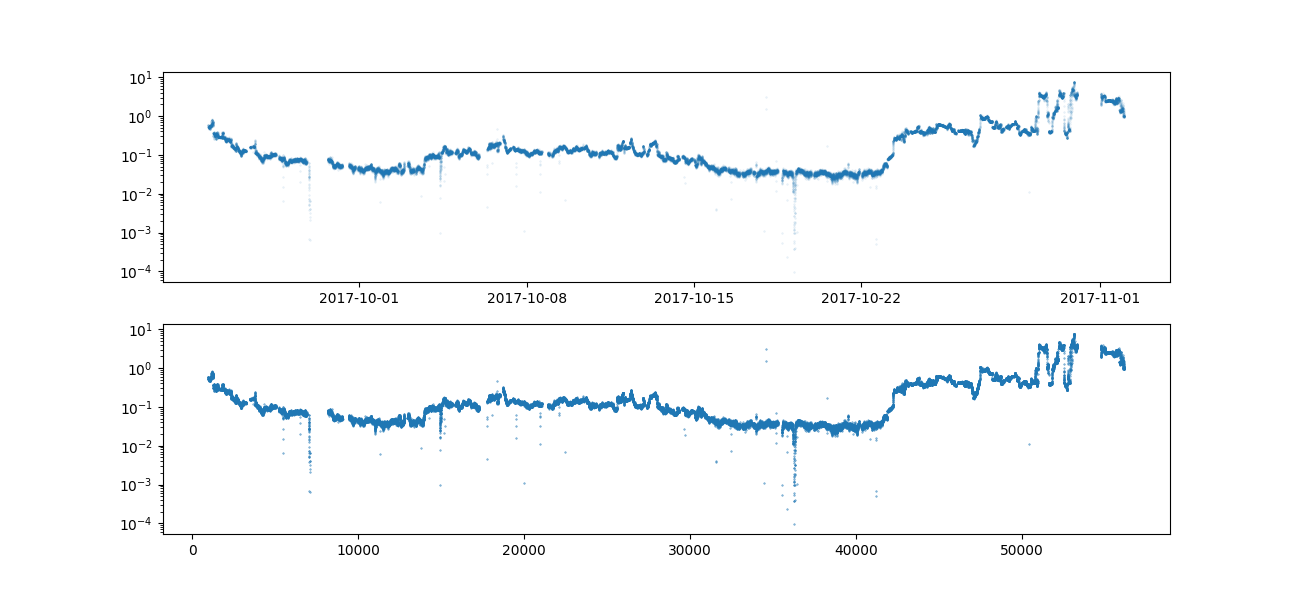

In [36]:
# create acx_chl variable that merges the ac9_chl and acs_chl (conditional added to check if ac9 is  available) 
if 'ac9_chl_adj' in acs.keys():
    acs["acx_chl"] = (['time'], np.nanmean(np.asarray([acs['ac9_chl_adj'].values, acs['acs_chl'].values]), axis=0) )
    acs["acx_chl"].attrs = {"acx_chl_units":"mg/m3",
                           "acx_chl_comment":"merged the ac9_chl and acs_chl",
                           }

# plot it
fig,ax = plt.subplots(2,1, figsize=[13,6])
# ax[0].semilogy(acs.time, acs.acx_chl, 'ro', lw=0.5, ms=5, mfc='none', alpha=0.05)
ax[0].semilogy(acs.time, acs.acs_chl, '.', lw=0., ms=1, mfc='none', alpha=0.15)
# ax[0].semilogy(acs.time, acs.ac9_chl_adj, 'k.', lw=0.5, ms=1, mfc='none', alpha=0.15)

# ax[1].semilogy(np.arange(len(acs.time)), acs.acx_chl, 'ro', lw=0.5, ms=5, mfc='none', alpha=0.15)
ax[1].semilogy(np.arange(len(acs.time)), acs.acs_chl, '.', lw=4, ms=1, mfc='none', alpha=0.8)
# ax[1].semilogy(np.arange(len(acs.time)), acs.ac9_chl_adj, 'k.', lw=0.5, ms=1, mfc='none', alpha=0.15)


In [37]:
acs

<xarray.Dataset>
Dimensions:                      (time: 56160, acs_wv: 176, ac9_wv: 9,
                                  bb3_wv: 3, hplc_time: 48)
Coordinates:
  * time                         (time) datetime64[ns] 2017-09-24 ... 2017-11...
  * acs_wv                       (acs_wv) float64 400.0 402.0 ... 748.0 750.0
  * ac9_wv                       (ac9_wv) float64 nan nan nan ... nan nan nan
  * bb3_wv                       (bb3_wv) float64 470.0 532.0 700.0
  * hplc_time                    (hplc_time) datetime64[ns] 2017-09-24T17:27:...
Data variables: (12/89)
    flow                         (time) float64 ...
    acs_chl                      (time) float64 nan nan nan ... 1.024 0.9879 nan
    acs_ap                       (time, acs_wv) float64 ...
    acs_ap_u                     (time, acs_wv) float64 ...
    acs_bp                       (time, acs_wv) float64 ...
    acs_bp_u                     (time, acs_wv) float64 ...
    ...                           ...
    hplc_PSP                     (hplc_time) object 0.6179151497517572 ... 4....
    hplc_Tcar                    (hplc_time) object 0.25040274703708904 ... 1...
    hplc_Tacc                    (hplc_time) object 0.36117981067451144 ... 2...
    hplc_Tpg                     (hplc_time) object 0.6736971857380811 ... 5....
    hplc_DP                      (hplc_time) object 0.24024698004546746 ... 1...
    hplc_file                    <U25 'Results DAN_2018_019.xlsx'

In [38]:
# manually identify (using plot above) noisy parts of the acx_chl timeseries
print(' check this manual step for each cruise')
i2rm = [[7000, 7100], # start and end index of noisy period 1 # AMT28
        [14820, 15000], # start and end index of noisy period 2
        [36200, 36400],  # start and end index of noisy period 3
       ]
#i2rm = [] # turned off as default
 

# set values to nan inside the above intervals
if 'acx_chl' in  acs.keys():
    for istart,tmp in enumerate(i2rm):
            acs['acx_chl'].values[tmp[0]:tmp[1]] = np.nan
            acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan
            acs['acs_ap_u'].values[tmp[0]:tmp[1], :] = np.nan

else:
            acs['acs_chl'].values[tmp[0]:tmp[1]] = np.nan
            acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan
            acs['acs_ap_u'].values[tmp[0]:tmp[1], :] = np.nan
            
                  

 check this manual step for each cruise


NameError: name 'tmp' is not defined

<IPython.core.display.Javascript object>


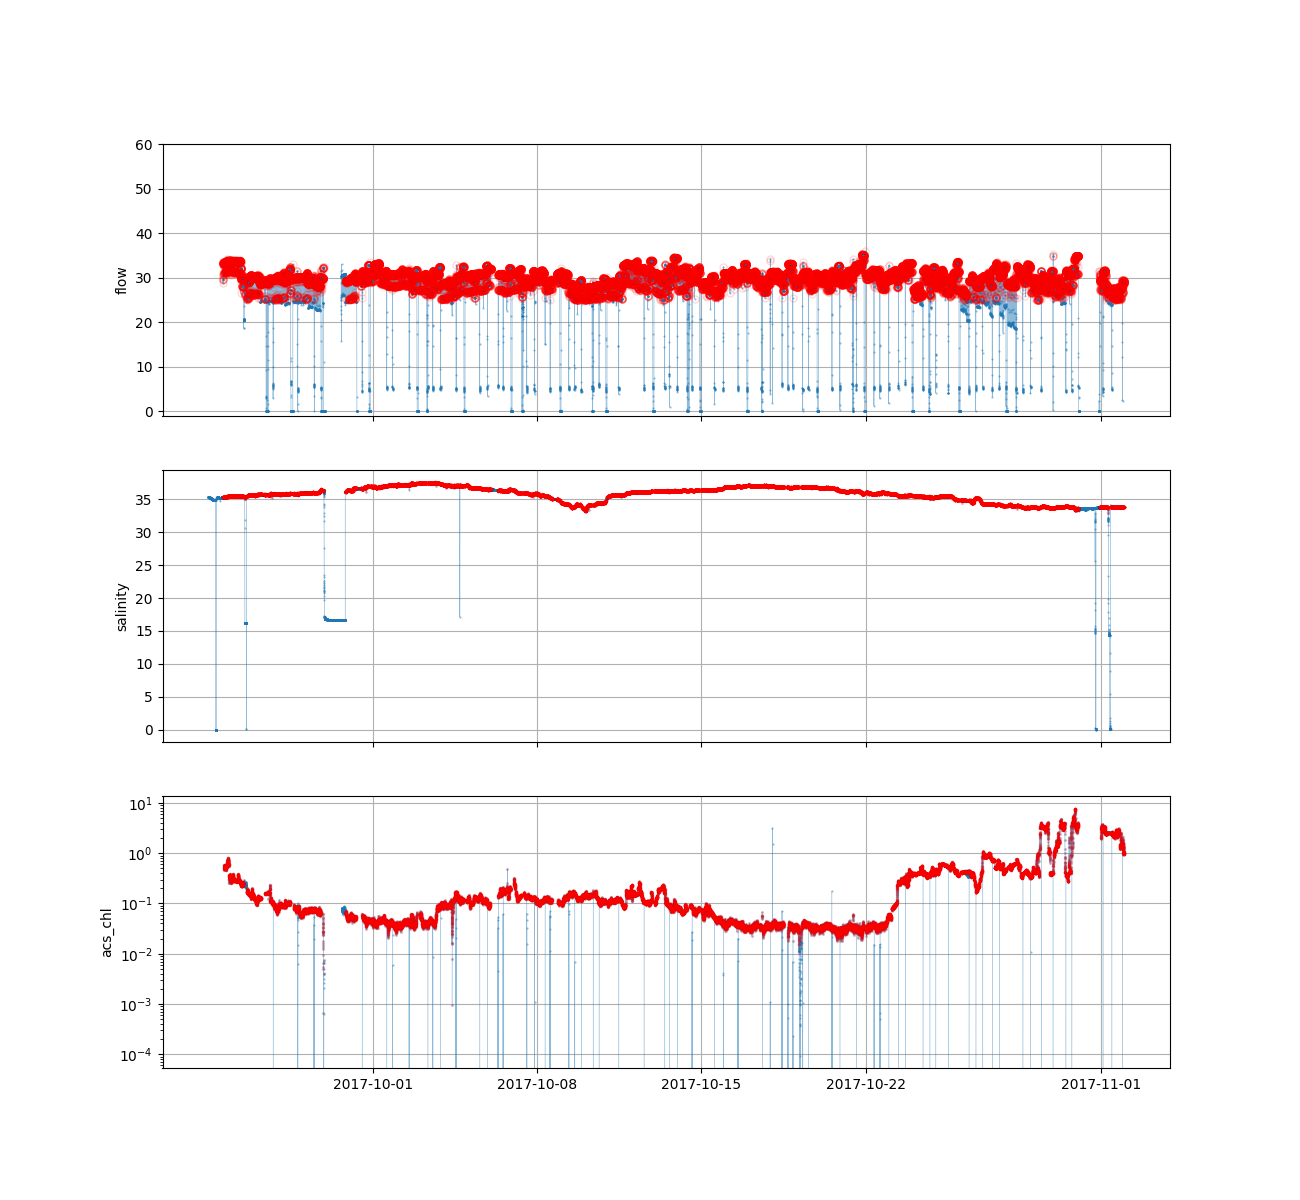

In [39]:
# filter acs data for MQ and noisy events
MIN_FLOW_RATE = 25
MIN_SAL = 33

i2f = np.where(  (acs.flow>MIN_FLOW_RATE) & (acs.uway_sal>MIN_SAL)   )[0]

fig, ax = plt.subplots(3,1, figsize=(13, 12), sharex=True)
ax[0].plot(acs.time, acs.flow, '.-', lw=0.5, ms=1, alpha=0.5)
ax[0].plot(acs.time[i2f], acs.flow[i2f], 'ro', lw=0.5, ms=5, mfc='none', alpha=0.15)
ax[0].set_ylabel('flow')
ax[0].grid('on')
ax[0].set_ylim([-1, 60])

# fig0, ax0 = plt.subplots(1, figsize=(15, 5))
ax[1].plot(acs.time, acs.uway_sal, '.-', lw=0.5, ms=1, alpha=0.5)
ax[1].plot(acs.time[i2f], acs.uway_sal[i2f], 'r.', lw=0.1, ms=3, mfc='none', alpha=0.15)
ax[1].set_ylabel('salinity')
ax[1].grid('on')

# fig2, ax2 = plt.subplots(1, figsize=(15, 5))
ax[2].semilogy(acs.time, acs.acs_chl, '.-', lw=0.5, ms=1, alpha=0.5)
ax[2].semilogy(acs.time[i2f], acs.acs_chl[i2f], 'r.', lw=0.1, ms=3, mfc='none', alpha=0.15)
ax[2].set_ylabel('acs_chl')
ax[2].grid('on')
# plt.ylim([1e-6, 10])


In [40]:
#df_UND = df_hplc_surf.loc[(df_hplc_surf['CTD'] == "UND") & (df_hplc_surf['Bottle'] == "UND")]  - specific to AMT 28? - fields not present in AMT27 meta 
#df_CTD = df_hplc_surf.loc[(df_hplc_surf['CTD'] != "UND") & (df_hplc_surf['Bottle'] != "UND")] -  specific to AMT 28? - fields not present in AMT27 meta
df_UND = df_hplc_surf # for now - just redefine 
df_CTD = df_hplc_surf

<IPython.core.display.Javascript object>


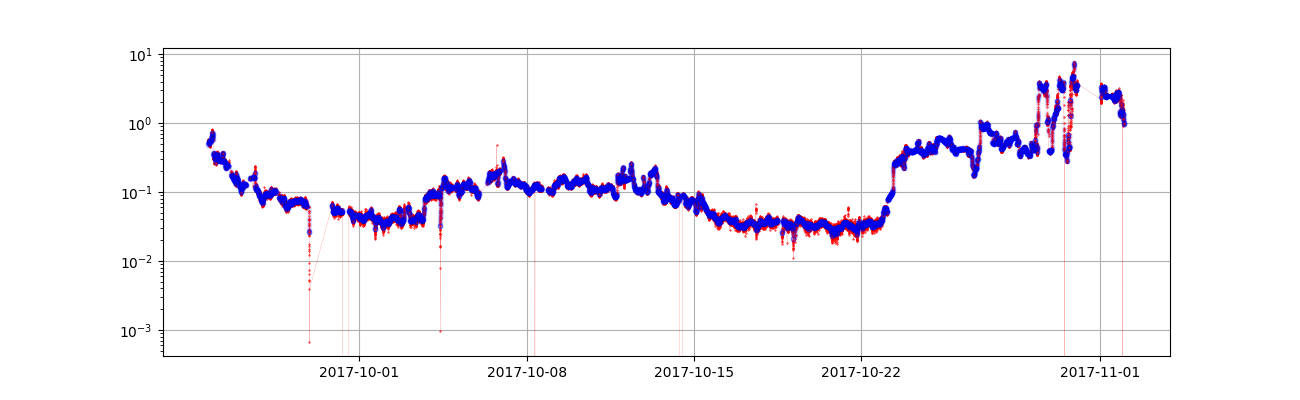

In [41]:
# median filter data

MEDFILT_WIN = 31
if 'acx_chl' in  acs.keys():
    innan = np.where(~np.isnan(acs.acx_chl[i2f]))[0] # need to remove nans to prevent medfilt to be spiky near edges
    fig2, ax2 = plt.subplots(1, figsize=(13, 4))
    ax2.semilogy(acs.time[i2f][innan], acs.acx_chl[i2f][innan], 'r.-', lw=0.1, ms=1, mfc='none')
    ax2.semilogy(acs.time[i2f][innan], sg.medfilt(acs.acx_chl[i2f][innan], kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=3, mfc='none', alpha = 0.05)
    ax2.grid('on')
    # plt.ylim([1e-6, 10])

else:
    innan = np.where(~np.isnan(acs.acs_chl[i2f]))[0] # added
    fig2, ax2 = plt.subplots(1, figsize=(13, 4))
    ax2.semilogy(acs.time[i2f][innan], acs.acs_chl[i2f][innan], 'r.-', lw=0.1, ms=1, mfc='none')
    ax2.semilogy(acs.time[i2f][innan], sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=3, mfc='none', alpha = 0.05)
    ax2.grid('on')
    # plt.ylim([1e-6, 10])



# ax2.semilogy(acs.hplc_time, acs.hplc_pigs_Tot_Chl_a, 'go', ms=5, alpha=1)#, mfc='none')
# ax2.semilogy(df_CTD.index, df_CTD.Tot_Chl_a, 'ko', ms=7, alpha=1, mfc='none', zorder=60)
# ax2.scatter(df_CTD.index, df_CTD.Tot_Chl_a, c=df_CTD.Bottle.values, s=30, alpha=1, zorder=60, cmap = plt.get_cmap('inferno'), vmin=2, vmax=24)
# ax2.semilogy(df_UND.index, df_UND.Tot_Chl_a, 'ks', ms=7, alpha=0.85, mfc='c')


In [42]:
df_CTD.keys()

Index(['Label', 'Volume', 'DHI no', 'Chl_c3', 'Chl_c1c2', 'Chlide_a',
       'Phide_a', 'Perid', 'But-fuco', 'Fuco', 'Neo', 'Pras', 'Viola',
       'Hex-fuco', 'DHI_only_Astaxanthin', 'Diadino', 'Allo', 'Diato', 'Zea',
       'Lut', 'DHI_only_Chl_C2_MGDG', 'Tot_Chl_b', 'DV_Chl_a', 'MV_Chl_a',
       'Phytin_a', 'Alpha-beta-Car', 'SDY', 'Cast No.', 'lat', 'lon', 'depth',
       'Secchi Depth', 'Comments', 'Tot_Chl_a', 'Tot_Chl_c', 'Tchl', 'PPC',
       'PSC', 'PSP', 'Tcar', 'Tacc', 'Tpg', 'DP'],
      dtype='object')

In [43]:
# # merge HPCL and ACS data
# # see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate

# # create pandas series with HPLC Tot_Chl_a data
# ds_hplc_surf = pd.Series(df_hplc_surf.Tot_Chl_a.values, index = df_hplc_surf.index)

# # averages duplicate values
# ds_hplc_surf = ds_hplc_surf.groupby('date').mean() 

# # create pandas series with medfilt ACS data
# df_acs = pd.Series(sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31), index = acs.time.values[i2f][innan])


# df_hplc_acs = pd.DataFrame({'Tot_Chl_a': ds_hplc_surf, 'acs_chl': df_acs})

# df_hplc_acs = df_hplc_acs.interpolate('index').reindex(ds_hplc_surf.index)
# df_hplc_acs

<IPython.core.display.Javascript object>


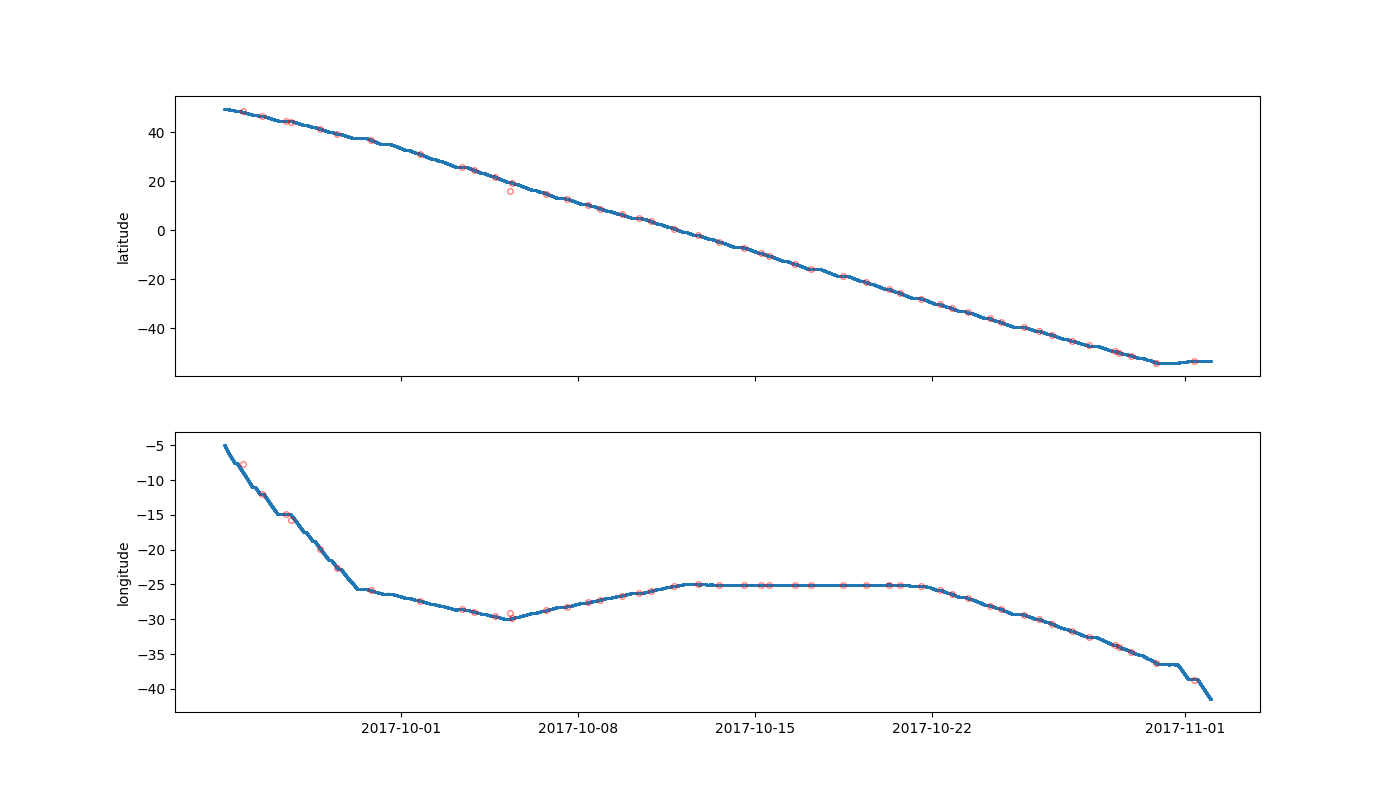

Text(0, 0.5, 'longitude')

In [44]:
# compare lat and lon of hplc and acs datasets
fig, ax = plt.subplots(2, 1, figsize = (14, 8), sharex = True)

ax[0].plot(acs.time, acs.uway_lat, '.', ms = 1, mfc = 'none')
ax[0].plot(acs.hplc_time, acs.hplc_lat, 'ro', ms = 4, mfc = 'none', alpha = 0.5)
ax[0].set_ylabel("latitude")
ax[1].plot(acs.time, acs.uway_lon, '.', ms = 1, mfc = 'none')
ax[1].plot(acs.hplc_time, acs.hplc_lon, 'ro', ms = 4, mfc = 'none', alpha = 0.5)
ax[1].set_ylabel("longitude")

In [45]:
df_CTD.keys()

Index(['Label', 'Volume', 'DHI no', 'Chl_c3', 'Chl_c1c2', 'Chlide_a',
       'Phide_a', 'Perid', 'But-fuco', 'Fuco', 'Neo', 'Pras', 'Viola',
       'Hex-fuco', 'DHI_only_Astaxanthin', 'Diadino', 'Allo', 'Diato', 'Zea',
       'Lut', 'DHI_only_Chl_C2_MGDG', 'Tot_Chl_b', 'DV_Chl_a', 'MV_Chl_a',
       'Phytin_a', 'Alpha-beta-Car', 'SDY', 'Cast No.', 'lat', 'lon', 'depth',
       'Secchi Depth', 'Comments', 'Tot_Chl_a', 'Tot_Chl_c', 'Tchl', 'PPC',
       'PSC', 'PSP', 'Tcar', 'Tacc', 'Tpg', 'DP'],
      dtype='object')

In [46]:

df_hplc_surf_new = df_UND
# merge HPCL and ACS data
# see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate
# here made with dataframe instead of series

# averages duplicate values
#df_hplc_surf_new = df_hplc_surf_new.groupby('time').mean()  - swicthed off for AMT 27

# create pandas series with medfilt ACS data
if 'acx_chl' in  acs.keys():
    df_acs = pd.Series(sg.medfilt(acs.acx_chl[i2f][innan], kernel_size=31), index = acs.time.values[i2f][innan])
    df_hplc_acs = pd.DataFrame({'Tot_Chl_a': df_hplc_surf_new.Tot_Chl_a, 'acx_chl': df_acs})
else: 
    df_acs = pd.Series(sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31), index = acs.time.values[i2f][innan])
    df_hplc_acs = pd.DataFrame({'Tot_Chl_a': df_hplc_surf_new.Tot_Chl_a, 'acs_chl': df_acs})

df_hplc_acs = df_hplc_acs.interpolate('index').reindex(df_hplc_surf_new.index)
    

In [47]:
# compute residuals and stats
rres = df_hplc_acs.acs_chl.values / df_hplc_acs.Tot_Chl_a.values - 1

delta = np.nanmedian(rres)
sigma = prcrng(rres)
N = len(rres)

print(delta, sigma, N)

-0.07378529880943258 0.11944447655085341 48


<IPython.core.display.Javascript object>


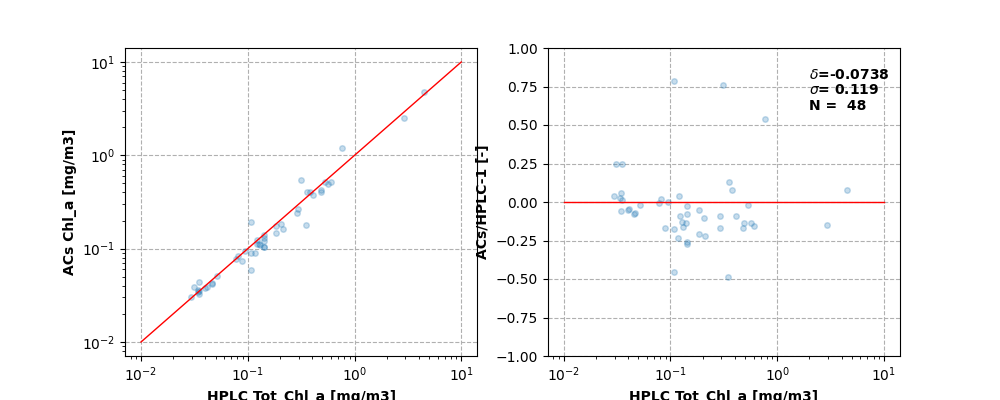

Text(2, 0.6, 'N =  48')

In [48]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl.values, 'o', ms=4, alpha=0.25)
x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACs Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('ACs/HPLC-1 [-]', fontweight='bold')
ax[1].set_ylim([-1, 1])
ax[1].text(2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
ax[1].text(2, 0.7, r'$\sigma$='+f'{sigma: 0.3}', fontweight='bold')
ax[1].text(2, 0.6, f'N = {N: 0}', fontweight='bold')


<IPython.core.display.Javascript object>


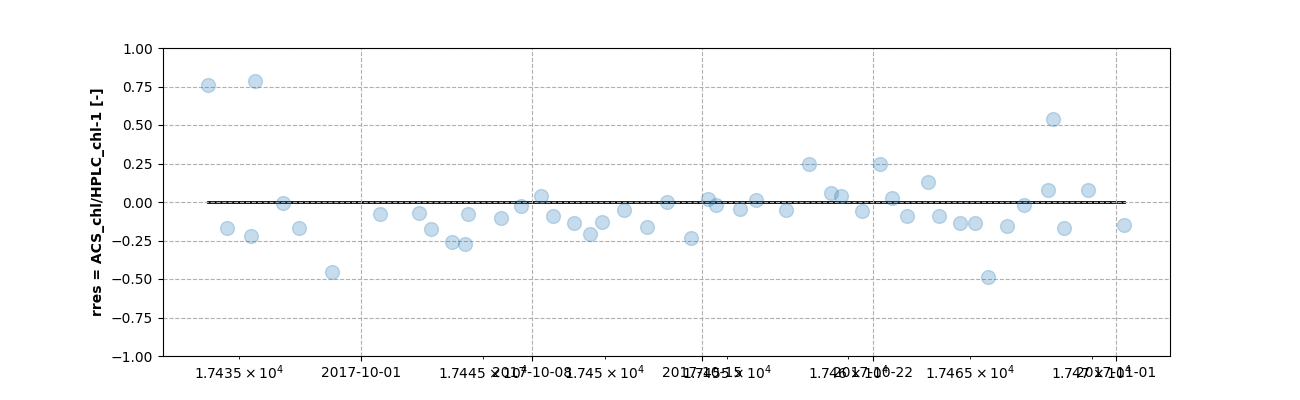

(-1.0, 1.0)

In [49]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.semilogx(df_hplc_acs.index.values, rres, 'o', ms=10, alpha=0.25, zorder=60)
ax.plot(df_hplc_acs.index.values, rres*0, 'k-', lw=2, zorder=1)
ax.set_ylabel('rres = ACS_chl/HPLC_chl-1 [-]', fontweight='bold')
ax.grid('on', ls='--')
ax.set_ylim([-1, 1])

In [50]:
ilrg_rres = np.where(abs(rres)>0.5)[0]
print(rres[ilrg_rres])
df_hplc_surf_new.iloc[ilrg_rres]

[0.759543628206403 0.7872674881212043 0.5371187164593831]


,Label,Volume,DHI no,Chl_c3,Chl_c1c2,Chlide_a,Phide_a,Perid,But-fuco,Fuco,...,Tot_Chl_a,Tot_Chl_c,Tchl,PPC,PSC,PSP,Tcar,Tacc,Tpg,DP
time,,,,,,,,,,,,,,,,,,,,,
2017-09-24 17:27:00,UW001,2,1,0.037777,0.045214,0.006699,0,0.005403,0.029827,0.046949,...,0.312517,0.08299,0.423294,0.055782,0.194621,0.617915,0.250403,0.36118,0.673697,0.240247
2017-09-26 15:00:00,UW010,4,4,0.006418,0.009704,0.000841,0,0.002423,0.010068,0.004947,...,0.107249,0.016122,0.130933,0.06185,0.039312,0.170245,0.101162,0.124846,0.232095,0.09614
2017-10-29 09:26:00,UW185,2,45,0.072062,0.211628,0.067155,0,0.011957,0.021289,0.313702,...,0.770377,0.28369,1.073232,0.109522,0.425365,1.498597,0.534887,0.837742,1.608119,0.455537


In [51]:
df_hplc_surf_new.iloc[ilrg_rres].index.dayofyear
# tt.tm_yday

Int64Index([267, 269, 302], dtype='int64', name='time')

In [52]:
df_hplc_surf_new.iloc[ilrg_rres].keys()

Index(['Label', 'Volume', 'DHI no', 'Chl_c3', 'Chl_c1c2', 'Chlide_a',
       'Phide_a', 'Perid', 'But-fuco', 'Fuco', 'Neo', 'Pras', 'Viola',
       'Hex-fuco', 'DHI_only_Astaxanthin', 'Diadino', 'Allo', 'Diato', 'Zea',
       'Lut', 'DHI_only_Chl_C2_MGDG', 'Tot_Chl_b', 'DV_Chl_a', 'MV_Chl_a',
       'Phytin_a', 'Alpha-beta-Car', 'SDY', 'Cast No.', 'lat', 'lon', 'depth',
       'Secchi Depth', 'Comments', 'Tot_Chl_a', 'Tot_Chl_c', 'Tchl', 'PPC',
       'PSC', 'PSP', 'Tcar', 'Tacc', 'Tpg', 'DP'],
      dtype='object')

In [53]:
# find dates of large rres
if 'acx_chl' in  acs.keys():
    r = df_hplc_acs.acx_chl / df_hplc_acs.Tot_Chl_a - 1
else:
    r = df_hplc_acs.acs_chl / df_hplc_acs.Tot_Chl_a - 1
ii = np.where(abs(r)>0.4)[0]
print(r[ii])
# iss = 2
# [df_hplc_acs.Tot_Chl_a[ii][iss], df_hplc_acs.acx_chl[ii][i

time
2017-09-24 17:27:00    0.759544
2017-09-26 15:00:00    0.787267
2017-09-29 19:00:00   -0.452726
2017-10-26 17:17:00   -0.484194
2017-10-29 09:26:00    0.537119
dtype: object


In [54]:
# # de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
# df_hplc_acs.acs_chl_debiased = df_hplc_acs.acs_chl*(1-delta)

In [55]:
# fit data to power law
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x**b
if 'acx_chl' in  acs.keys():
    popt, pcov = curve_fit(func, 0.014*df_hplc_acs.acx_chl.values, df_hplc_acs.Tot_Chl_a.values)
else:
    popt, pcov = curve_fit(func, 0.014*df_hplc_acs.acs_chl.values, df_hplc_acs.Tot_Chl_a.values)
perr = np.sqrt(np.diag(pcov)) # parameter uncertainty 

print("chl_HPLC = a * chl_ACS^b " )

print("a = " + f'{popt[0]:.1f} ' + "+/- " + f'{perr[0]:.1f}' )
print("b = " + f'{popt[1]:.3f} ' + "+/- " + f'{perr[1]:.3f}' )



chl_HPLC = a * chl_ACS^b 
a = 61.7 +/- 5.1
b = 0.962 +/- 0.026


In [56]:
# # compute resuduals and stats
# rres = df_hplc_acs.acs_chl_debiased.values/df_hplc_acs.Tot_Chl_a.values-1

# delta = np.nanmedian(rres)
# sigma = prcrng(rres)
# N = len(rres)

# print(delta, sigma, N)

In [57]:
# fig, ax = plt.subplots(1,2, figsize=(10, 4))

# ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl_debiased.values, 'o', ms=4, alpha=0.25)
# x = np.logspace(np.log10(0.01), np.log10(10), 100)
# ax[0].loglog(x, x, 'r-', lw=1)
# ax[0].grid('on', ls='--')
# ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
# ax[0].set_ylabel('ACS Chl_a [mg/m3]', fontweight='bold')

# ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
# ax[1].semilogx(x, x*0, 'r-', lw=1)
# ax[1].grid('on', ls='--')
# ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
# ax[1].set_ylabel('ACS/HPLC-1 [-]', fontweight='bold')

# ax[1].text(2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
# ax[1].text(2, 0.7, r'$\sigma$='+f'{sigma: 0.3}', fontweight='bold')
# ax[1].text(2, 0.6, f'N = {N: 0}', fontweight='bold')


In [58]:

# de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
if 'acx_chl' in acs.keys(): # case with merged acs ac9
    innan = np.where(~np.isnan(acs.acx_chl[i2f]))[0]
    acs['acx_chl_debiased'] = acs.acx_chl*(1-delta)
    # acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
    acs_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan],
                                   'lon [degE]': acs.uway_lon[i2f][innan],
                                   'acs_chl_debiased [mg_m3]': acs.acx_chl_debiased[i2f][innan]
                                  }  ,
                          index = acs.time.values[i2f][innan])
    acs_out.index.rename('date_time [UTC]', inplace = True)
else:
    innan = np.where(~np.isnan(acs.acs_chl[i2f]))[0]
    acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
    # acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
    acs_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan],
                                   'lon [degE]': acs.uway_lon[i2f][innan],
                                   'acs_chl_debiased [mg_m3]': acs.acs_chl_debiased[i2f][innan]
                                  }  ,
                          index = acs.time.values[i2f][innan])
    acs_out.index.rename('date_time [UTC]', inplace = True)


In [59]:
# add attributes to acs_chl_debiased

# add attributes to acs_chl_debiased
if 'acx_chl' in acs.keys(): # case with merged acs ac9
    acs.acx_chl_debiased.attrs["debiasing_equation"] = "acs.acx_chl_deiased = acs.acx_chl*(1-delta)"
    acs.acx_chl_debiased.attrs["delta"] = delta
    acs.acx_chl_debiased.attrs["sigma"] = sigma
    acs.acx_chl_debiased.attrs["units"] = "mg/m3"
    acs.acx_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acx_chl/HPLC_Tot_Chl_a-1, based on surface data"
    acs.acx_chl_debiased.attrs["HPLC_Tot_chla"] = df_hplc_acs.Tot_Chl_a.values
    acs.acx_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
    acs.acx_chl_debiased.attrs["acx_chl"] = df_hplc_acs.acx_chl.values
    acs.acx_chl_debiased.attrs["acx_chl_units"] = "mg/m3"
    acs.acx_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
    acs.acx_chl_debiased.attrs["match_up_dates"] = df_hplc_acs.index.format()
else: # just acs
    acs.acs_chl_debiased.attrs["debiasing_equation"] = "acs.acs_chl_deiased = acs.acs_chl*(1-delta)"
    acs.acs_chl_debiased.attrs["delta"] = delta
    acs.acs_chl_debiased.attrs["sigma"] = sigma
    acs.acs_chl_debiased.attrs["units"] = "mg/m3"    
    acs.acs_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
    acs.acs_chl_debiased.attrs["HPLC_Tot_chla"] = np.array(list(df_hplc_acs.Tot_Chl_a.values)) # issues with d-type; this removes object class.
    acs.acs_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"    
    acs.acs_chl_debiased.attrs["acs_chl"] = df_hplc_acs.acs_chl.values
    acs.acs_chl_debiased.attrs["acs_chl_units"] = "mg/m3"
    acs.acs_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
    acs.acs_chl_debiased.attrs["match_up_dates"] = df_hplc_acs.index.format()
        


In [60]:
#acs_filtered2 = acs_filtered  #- not needed?
#acs_filtered2 = acs_filtered2.rename_vars({'time_': 'time'}, )


In [68]:
# create new filtered acs dataframe
#acs2 = acs.reset_index('time') # this is needed only for AMT29

# i2kp = np.where(  (acs.acs_ap[i2f,10][innan]>0) | (np.isreal(acs.ay440))  )[0]         # this removes ay data
#i2kp = np.where(  (acs2.acs_ap[:,10]>0)   ) [0]
# i2kp = np.where(  acs.acs_ap[i2f,10][innan]>0  )[0]         # this removes ay data
# ix = xr.DataArray(acs.time[i2f][innan][i2kp], dims=['time'])
#ix = xr.DataArray(acs2.time[i2kp], dims=['time'])


# AMT27 - sequential version of filtering (no need to define acs2 structure, or filter-out ay) 

#step x - # filters w.r.t. i2fn (mQ interval + previous manual spike removal) and innan
ix = xr.DataArray(acs.time[i2f][innan], dims=['time']) 
acs_filtered_x = acs.sel(time = ix)


#step y - # filters w.r.t. ap (10the elemeent) being > 0
i2kp = np.where((acs_filtered_x.acs_ap[:,10] > 0)) [0]
iy = xr.DataArray(acs_filtered_x.time[i2kp], dims=['time']) 
acs_filtered_xy = acs.sel(time = ix)



<IPython.core.display.Javascript object>


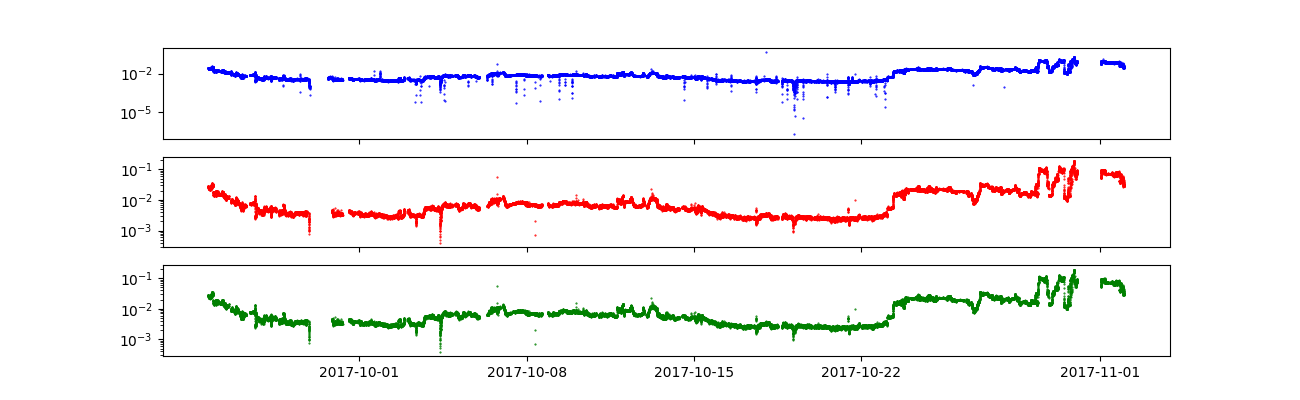

In [62]:
# In[64]:


# plot to check         

fig, [ax, ax2, ax3] = plt.subplots(3,1, figsize=(13, 4), sharex=True)

iwv = np.where(acs_filtered_x.acs_wv==490)[0]
ax.semilogy(acs.time[:], acs.acs_ap[:,iwv], 'b.', ms=1)

iwv_x = np.where(acs_filtered_x.acs_wv==490)[0]
ax2.semilogy(acs_filtered_x.time[:], acs_filtered_x.acs_ap[:,iwv_x], 'r.', ms=1)

iwv_y = np.where(acs_filtered_xy.acs_wv==490)[0]
ax3.semilogy(acs_filtered_xy.time[:], acs_filtered_xy.acs_ap[:,iwv_y], 'g.', ms=1)
#ax.semilogy(acs_filtered.time[:], sg.medfilt(x, 151), 'b.', ms=1)
#ax.semilogy(acs_filtered2.time, acs_filtered2.acs_ap[:,iwv], 'ro', ms=1, mfc='none', alpha=0.5)
#ax.grid('on')





In [63]:
#test that for similar keys between AMT27 and AMT29

#load AMT29 (baseline for netcdf)
path_nc_29 = '/data/lazarev1/backup/cruise_data/AMT29/Public_Read_Only_Copy/DY110_Public/Optics_group/Processed/Underway/Step3/amt29_final_with_debiased_chl.nc'
nc_data_29 = xr.open_dataset(path_nc_29)  


#test for common and unqiue keys
keys_27 = list(acs_filtered_xy.keys())
keys_29 = list(nc_data_29.keys())
common_keys = set(keys_27).intersection(set(keys_29)) # keys contained in both cruises
extra_keys_27 =  set(keys_27) ^ common_keys # extra keys in AMT 27
extra_keys_29 = set(keys_29) ^ common_keys # extra keys in AMT29

print('common keys')
print(common_keys)

print('/n extra keys in amt27')
print(extra_keys_27)

# manual clean up of AMT 27 keys
acs_filtered_xy = acs_filtered_xy.rename_vars({"uway_lon": "uway_long"})
acs_filtered_xy = acs_filtered_xy.drop("ac9_N")
acs_filtered_xy = acs_filtered_xy.drop("ac9_chl")

print('/n extra keys in amt29')
print(extra_keys_29)

common keys
{'hplc_comments', 'hplc_PSC', 'uway_conductivity', 'hplc_MV_Chl_a', 'acs_chl', 'uway_roll', 'hplc_Zea', 'uway_wind_vel', 'uway_par1', 'hplc_Tot_Chl_c', 'hplc_Pras', 'uway_fluo', 'bb3_bbp_corr', 'hplc_Diadino', 'uway_baro', 'hplc_Tot_Chl_a', 'hplc_Tpg', 'hplc_Lut', 'hplc_Viola', 'hplc_Alpha-beta-Car', 'hplc_Phide_a', 'flow', 'hplc_PPC', 'uway_par2', 'uway_sal', 'acs_ap', 'hplc_Phytin_a', 'uway_air_temp', 'hplc_Diato', 'cstar_cp', 'uway_tir2', 'uway_pitch', 'uway_flowrate', 'acs_chl_debiased', 'uway_heading', 'hplc_But-fuco', 'hplc_Fuco', 'ctd_sst', 'uway_lat', 'hplc_DV_Chl_a', 'uway_sst', 'hplc_Neo', 'hplc_Allo', 'hplc_Tchl', 'hplc_PSP', 'hplc_Chl_c1c2', 'bb3_bbp', 'hplc_DP', 'uway_humidity', 'hplc_Chlide_a', 'hplc_Tcar', 'uway_tir1', 'hplc_Tot_Chl_b', 'acs_ap_u', 'acs_N', 'hplc_lon', 'acs_bp', 'acs_bp_u', 'acs_cp', 'hplc_depth', 'bb3_bbp_err', 'hplc_Hex-fuco', 'hplc_Chl_c3', 'hplc_lat', 'cstar_cp_err', 'bb3_bb02_err', 'uway_depthm', 'ctd_sal', 'acs_cp_u', 'uway_gndcourse', 

In [64]:
#test for common and unqiue keys after clean up
keys_27 = list(acs_filtered_xy.keys())
keys_29 = list(nc_data_29.keys())
common_keys = set(keys_27).intersection(set(keys_29)) # keys contained in both cruises
extra_keys_27 =  set(keys_27) ^ common_keys # extra keys in AMT 27
extra_keys_29 = set(keys_29) ^ common_keys # extra keys in AMT29

print('common keys')
print(common_keys)

print('/n extra keys in amt27')
print(extra_keys_27) # I think extra keys are now reduced to eiter HPLC metadata differences, or DHI only pigments 

print('/n extra keys in amt29')
print(extra_keys_29)  # I think extra keys are now reduced to eiter HPLC metadata differences, or cdom (_y) quantities 

common keys
{'hplc_comments', 'hplc_PSC', 'uway_conductivity', 'hplc_MV_Chl_a', 'acs_chl', 'uway_roll', 'hplc_Zea', 'uway_wind_vel', 'uway_par1', 'hplc_Tot_Chl_c', 'hplc_Pras', 'uway_fluo', 'bb3_bbp_corr', 'hplc_Diadino', 'uway_baro', 'hplc_Tot_Chl_a', 'hplc_Tpg', 'hplc_Lut', 'hplc_Viola', 'hplc_Alpha-beta-Car', 'hplc_Phide_a', 'flow', 'hplc_PPC', 'uway_par2', 'uway_sal', 'acs_ap', 'hplc_Phytin_a', 'uway_air_temp', 'hplc_Diato', 'cstar_cp', 'uway_tir2', 'uway_pitch', 'uway_flowrate', 'acs_chl_debiased', 'uway_long', 'uway_heading', 'hplc_But-fuco', 'hplc_Fuco', 'ctd_sst', 'uway_lat', 'hplc_DV_Chl_a', 'uway_sst', 'hplc_Neo', 'hplc_Allo', 'hplc_Tchl', 'hplc_PSP', 'hplc_Chl_c1c2', 'bb3_bbp', 'hplc_DP', 'uway_humidity', 'hplc_Chlide_a', 'hplc_Tcar', 'uway_tir1', 'hplc_Tot_Chl_b', 'acs_ap_u', 'acs_N', 'hplc_lon', 'acs_bp', 'acs_bp_u', 'acs_cp', 'hplc_depth', 'bb3_bbp_err', 'hplc_Hex-fuco', 'hplc_Chl_c3', 'hplc_lat', 'cstar_cp_err', 'bb3_bb02_err', 'uway_depthm', 'ctd_sal', 'acs_cp_u', 'uway

<IPython.core.display.Javascript object>


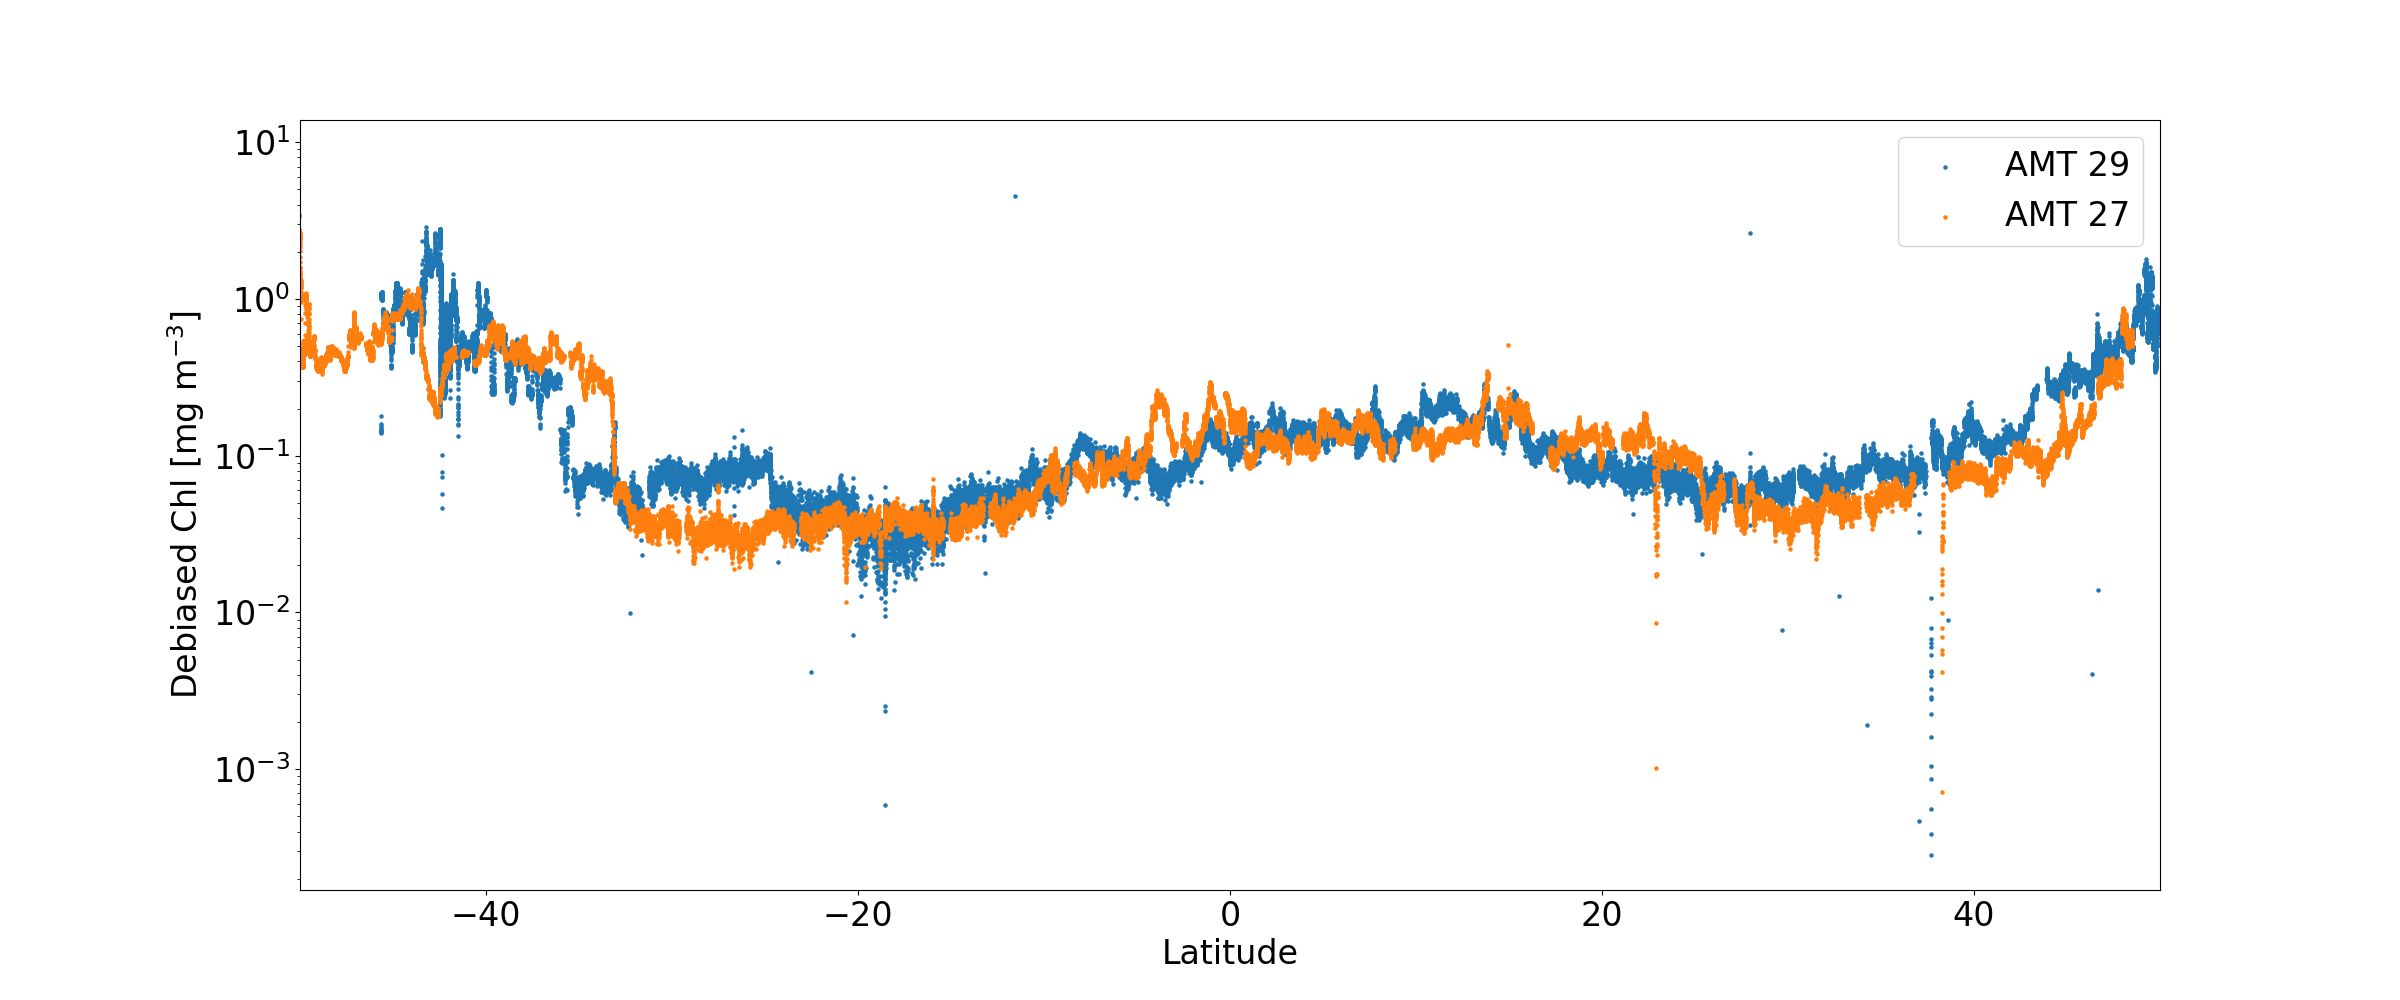

Text(0, 0.5, 'Debiased Chl [mg m$^{-3}$]')

In [65]:
# example plot comparing AMT27 and AMT29 Chl output 

#chl
plt.figure(figsize=(24,10))
plt.rc('font', size=24)
plt.scatter(nc_data_29['uway_lat'].data , nc_data_29['acs_chl_debiased'].data, s=5, label='AMT 29')
plt.scatter(acs_filtered_xy['uway_lat'], acs_filtered_xy['acs_chl_debiased'], s=5,label='AMT 27')
plt.gca().set_yscale('log')
plt.legend()
plt.xlabel('Latitude')
plt.xlim(-50,50)
plt.ylabel('Debiased Chl [mg m$^{-3}$]')
    
    

<IPython.core.display.Javascript object>


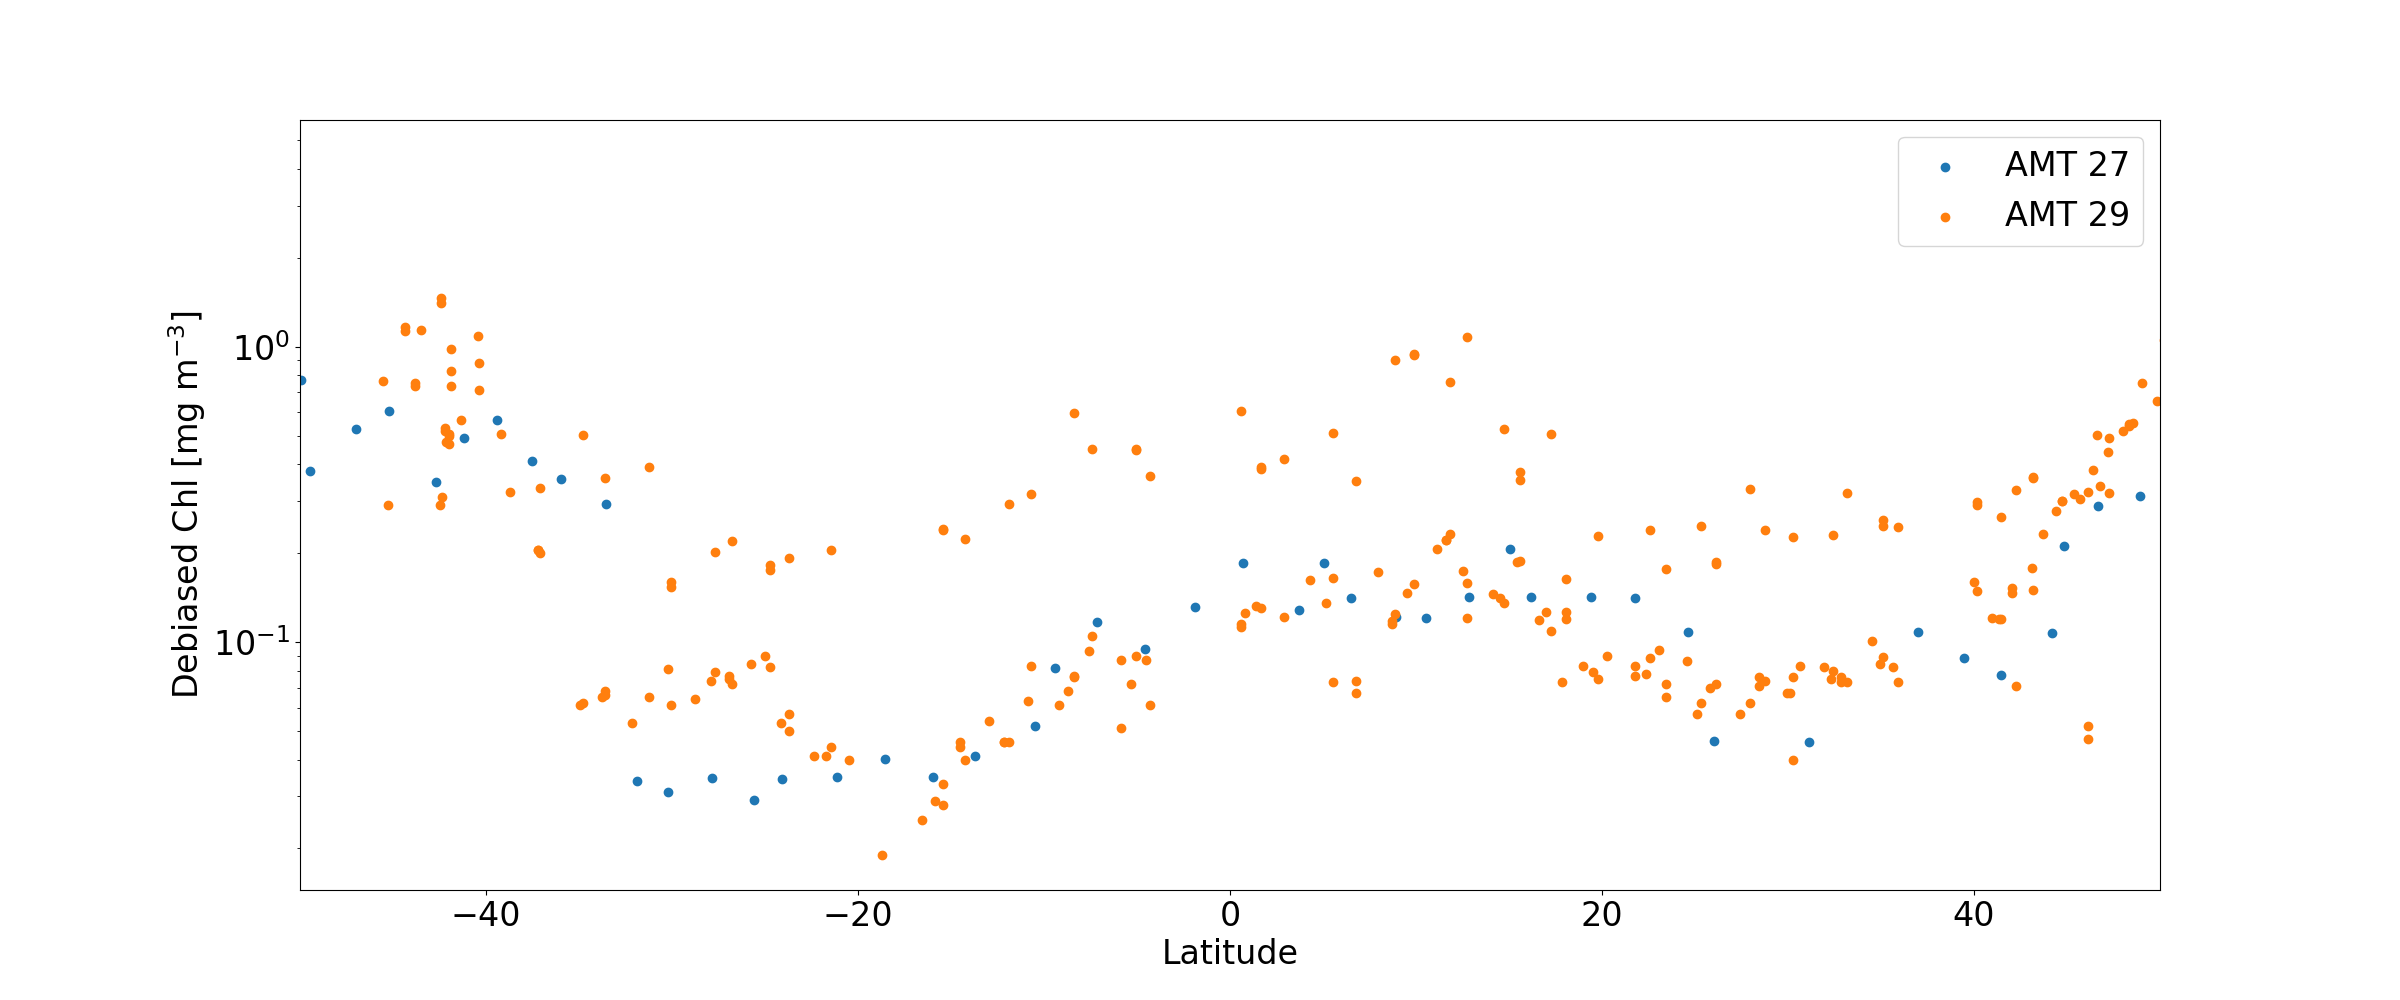

Text(0, 0.5, 'Debiased Chl [mg m$^{-3}$]')

In [66]:
plt.figure(figsize=(24,10))
plt.rc('font', size=24)
plt.scatter(acs_filtered_xy['hplc_lat'],acs_filtered_xy['hplc_Tot_Chl_a'],  label='AMT 27')
plt.scatter(nc_data_29['hplc_lat'].data,  nc_data_29['hplc_Tot_Chl_a'].data,  label='AMT 29')
plt.gca().set_yscale('log')
plt.legend()
plt.xlabel('Latitude')
plt.xlim(-50,50)
plt.ylabel('Debiased Chl [mg m$^{-3}$]')
#plt.legend()
#plt.xlabel('Latitude [deg C]')
#plt.ylabel('Air Temp')

In [67]:
# save updated NetCDF file

#acs_filtered2.to_netcdf(DIN_acs+fn_acs[:-3]+'_with_debiased_chl.nc')
#acs_filtered2.close()

#acs.to_netcdf(DIN_acs+fn_acs[:-3]+'_with_debiased_chl.nc')
#acs.close()


acs_filtered_xy.to_netcdf(DIN_acs+fn_acs[:-3]+'_with_debiased_chl.nc')
acs_filtered_xy.close()
